# Full Feature Engineering/ LGBM by Meter Type Predictions


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()
import gc
from tqdm import tqdm_notebook as tqdm

In [4]:
plt.style.use("seaborn")
sns.set(font_scale=1)

seed = 777
random.seed(seed)

## Set up Training data preprocess functions

In [5]:
## Function to reduce the DF memory consumption
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
#Function for adding lagged features on the weather data
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [7]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]

In [8]:
# Creation of time features: hour, day of the week, weekend indicator based on a corresponding list of major US holidays.
def preprocess(df):
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.weekday
    df["week"] = df["timestamp"].dt.week

In [10]:
weather_train = pd.read_csv(('ashrae-energy-prediction/weather_train.csv'), parse_dates=['timestamp'])
weather_test = pd.read_csv(('ashrae-energy-prediction/weather_test.csv'), parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather
gc.collect();

## Prepare timestamp alignment functions

In [11]:
# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 15, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 15)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    del df['offset']
    return df

In [12]:
del temp_skeleton;
gc.collect();

## Read in  training data 

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold

/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [14]:
train_df = pd.read_csv('ashrae-energy-prediction/train.csv', parse_dates = ['timestamp'])
building = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [12]:
weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}

In [13]:
weather_train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', dtype = weather_dtypes, parse_dates=['timestamp'])

## Feature Engineering

1. Log + 1 transform on meter readings(target) to reduce effect of outliers during training
2. Remove the first section of 0 data for the site 1 buildings in the training set. 
3. Creation of time features: hour, day of the week, weekend indicator based on a corresponding list of major US holidays.
4. Timestamp align of weather data and interpolation of nan data
5. Creation of aggregation features for each building: median, min, max, std, mean
6. Add lag features of weather data with 3 hour and 72 hour lookback
7. Label encoding of primary use type of each building
8. Reduce memory usage
9. Merge building metadata and weather data to training set to create one large dataset
10. Convert timestamp field to pandas datetime object to create time based features
11. Log + 1 transform on building squarefoot field
12. Sort values by timestamp
13. Merge building metadata and weather data to training set to create one large dataset
14. For the LGBM model, I will not impute NaN values as the model is good at dealing with those without imputation

In [14]:

train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [15]:
preprocess(train_df)

In [16]:
train_df

,building_id,meter,timestamp,meter_reading,meter_reading_log1p,is_holiday,hour,day_of_week,week
103,105,0,2016-01-01 00:00:00,23.3036,3.190624,1,0,4,53
104,106,0,2016-01-01 00:00:00,0.3746,0.318163,1,0,4,53
105,106,3,2016-01-01 00:00:00,0.0000,0.000000,1,0,4,53
106,107,0,2016-01-01 00:00:00,175.1840,5.171529,1,0,4,53
107,108,0,2016-01-01 00:00:00,91.2653,4.524668,1,0,4,53
...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500,2.277267,0,23,5,52
20216096,1445,0,2016-12-31 23:00:00,4.8250,1.762159,0,23,5,52
20216097,1446,0,2016-12-31 23:00:00,0.0000,0.000000,0,23,5,52
20216098,1447,0,2016-12-31 23:00:00,159.5750,5.078761,0,23,5,52


In [17]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

In [18]:
train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [19]:
weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [20]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [21]:
le = LabelEncoder()
building['primary_use'] = building['primary_use'].astype(str)
building['primary_use'] = le.fit_transform(building['primary_use']).astype(np.int8)

In [22]:
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)
building = reduce_mem_usage(building)

gc.collect();

Memory usage of dataframe is 1705.45 MB
Memory usage after optimization is: 966.42 MB
Decreased by 43.3%
Memory usage of dataframe is 19.86 MB
Memory usage after optimization is: 35.19 MB
Decreased by -77.2%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 60.8%


In [23]:
debug = False  

## Set up model and full training set

Split each training set by meter type for training. 4 models

In [24]:
category_cols = ['building_id', 'site_id', 'primary_use', 'hour', 'week', 'day_of_week', 'is_holiday', 'meter']  
feature_cols = ['square_feet', 'year_built'] + [
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [25]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [26]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'rmse'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 100
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['rmse'],
           'valid/mae': model.best_score['valid_1']['rmse']}
    return model, y_pred_valid, log

In [27]:
folds = 5
seed = 777
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

## Train Model

target_meter 0 (11714696, 37)
cat_features [29, 30, 31, 32, 33, 34, 35, 36]
train 9371756 valid 2342940
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 0.817716	valid_1's rmse: 0.836499
[40]	training's rmse: 0.613922	valid_1's rmse: 0.671135
[60]	training's rmse: 0.549921	valid_1's rmse: 0.639481
[80]	training's rmse: 0.51327	valid_1's rmse: 0.623553
[100]	training's rmse: 0.483957	valid_1's rmse: 0.611065
[120]	training's rmse: 0.461492	valid_1's rmse: 0.605127
[140]	training's rmse: 0.44505	valid_1's rmse: 0.596997
[160]	training's rmse: 0.430979	valid_1's rmse: 0.590424
[180]	training's rmse: 0.419874	valid_1's rmse: 0.586987
[200]	training's rmse: 0.411094	valid_1's rmse: 0.583181
[220]	training's rmse: 0.403528	valid_1's rmse: 0.580414
[240]	training's rmse: 0.396777	valid_1's rmse: 0.577341
[260]	training's rmse: 0.390268	valid_1's rmse: 0.576002
[280]	training's rmse: 0.385153	valid_1's rmse: 0.573922
[300]	training's rmse: 0.380193	valid_1's rmse: 0.572896
[320]	training's rmse: 0.375145	valid_1's rmse: 0.571802
[340]	training's rmse: 0.37073	v

10

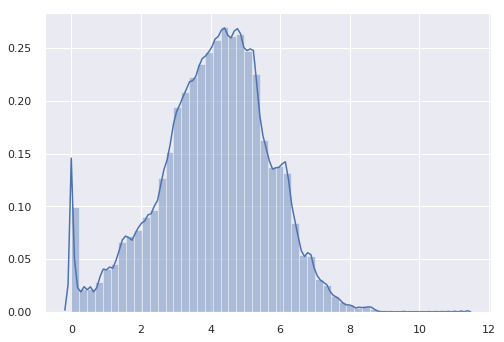

In [28]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 1 (4182440, 37)
cat_features [29, 30, 31, 32, 33, 34, 35, 36]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.53662	valid_1's rmse: 1.67743
[40]	training's rmse: 1.27627	valid_1's rmse: 1.39058
[60]	training's rmse: 1.16128	valid_1's rmse: 1.31855
[80]	training's rmse: 1.0964	valid_1's rmse: 1.29224
[100]	training's rmse: 1.05095	valid_1's rmse: 1.27978
[120]	training's rmse: 1.01941	valid_1's rmse: 1.26683
[140]	training's rmse: 0.993955	valid_1's rmse: 1.25571
[160]	training's rmse: 0.972768	valid_1's rmse: 1.24896
[180]	training's rmse: 0.955926	valid_1's rmse: 1.24303
[200]	training's rmse: 0.940943	valid_1's rmse: 1.23902
[220]	training's rmse: 0.92831	valid_1's rmse: 1.23454
[240]	training's rmse: 0.916996	valid_1's rmse: 1.23125
[260]	training's rmse: 0.904229	valid_1's rmse: 1.22968
[280]	training's rmse: 0.891916	valid_1's rmse: 1.22602
[300]	training's rmse: 0.882093	valid_1's rmse: 1.

10

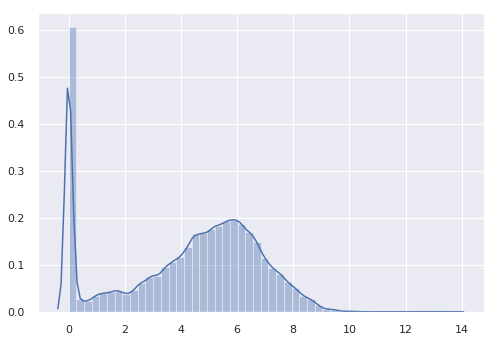

In [29]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 2 (2708713, 37)
cat_features [29, 30, 31, 32, 33, 34, 35, 36]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.59011	valid_1's rmse: 1.78107
[40]	training's rmse: 1.3239	valid_1's rmse: 1.56875
[60]	training's rmse: 1.21788	valid_1's rmse: 1.51084
[80]	training's rmse: 1.16489	valid_1's rmse: 1.49051
[100]	training's rmse: 1.12497	valid_1's rmse: 1.48107
[120]	training's rmse: 1.09761	valid_1's rmse: 1.47539
[140]	training's rmse: 1.07669	valid_1's rmse: 1.46904
[160]	training's rmse: 1.05848	valid_1's rmse: 1.46391
[180]	training's rmse: 1.04374	valid_1's rmse: 1.463
[200]	training's rmse: 1.02918	valid_1's rmse: 1.46262
[220]	training's rmse: 1.0185	valid_1's rmse: 1.45945
[240]	training's rmse: 1.0088	valid_1's rmse: 1.45621
[260]	training's rmse: 1.00014	valid_1's rmse: 1.45286
[280]	training's rmse: 0.992	valid_1's rmse: 1.44983
[300]	training's rmse: 0.984665	valid_1's rmse: 1.44814
[320]	t

10

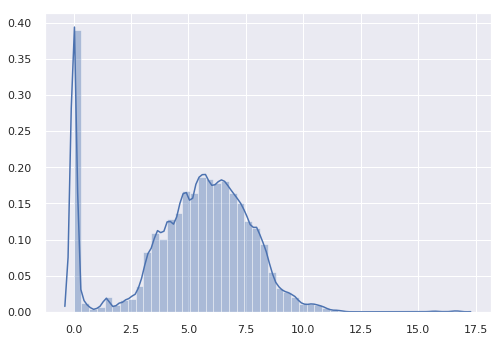

In [30]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 3 (1264037, 37)
cat_features [29, 30, 31, 32, 33, 34, 35, 36]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 100 rounds
[20]	training's rmse: 1.86225	valid_1's rmse: 2.05889
[40]	training's rmse: 1.55409	valid_1's rmse: 1.75538
[60]	training's rmse: 1.41381	valid_1's rmse: 1.63032
[80]	training's rmse: 1.34622	valid_1's rmse: 1.57746
[100]	training's rmse: 1.30464	valid_1's rmse: 1.56053
[120]	training's rmse: 1.27648	valid_1's rmse: 1.55234
[140]	training's rmse: 1.25462	valid_1's rmse: 1.54906
[160]	training's rmse: 1.23329	valid_1's rmse: 1.55281
[180]	training's rmse: 1.21391	valid_1's rmse: 1.5535
[200]	training's rmse: 1.1956	valid_1's rmse: 1.55646
[220]	training's rmse: 1.18236	valid_1's rmse: 1.55647
Early stopping, best iteration is:
[137]	training's rmse: 1.2581	valid_1's rmse: 1.54648
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 1.2581034979222219)]), 'valid_1': Ordered

10

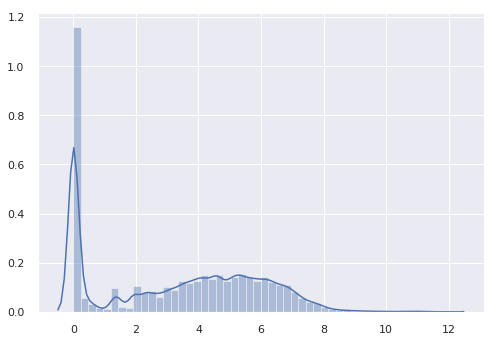

In [31]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

## Prepare Test Data


In [32]:
test_df = pd.read_csv('ashrae-energy-prediction/test.csv', parse_dates = ['timestamp'])
weather_test_df = pd.read_csv('ashrae-energy-prediction/weather_test.csv', parse_dates = ['timestamp'])

preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)


In [33]:
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

In [34]:
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

Memory usage of dataframe is 2942.68 MB
Memory usage after optimization is: 1153.21 MB
Decreased by 60.8%
Memory usage of dataframe is 48.65 MB
Memory usage after optimization is: 35.69 MB
Decreased by 26.6%


0

## Make Predictions of 4 meter types
Predictions are split on the 4 meter types

In [35]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [36]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 2h 51min 49s, sys: 1min 21s, total: 2h 53min 10s
Wall time: 46min 1s


10

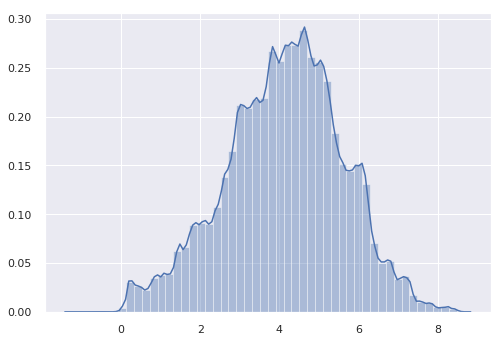

In [37]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 1h 20min 37s, sys: 31.1 s, total: 1h 21min 8s
Wall time: 21min 24s


22

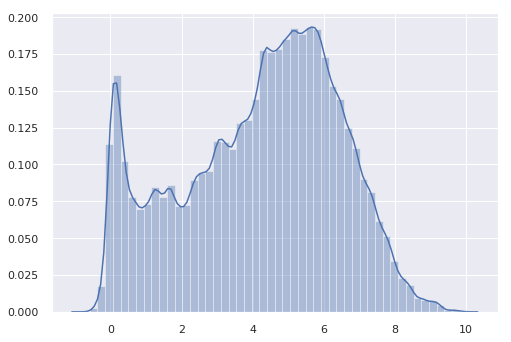

In [38]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 26min 38s, sys: 16.1 s, total: 26min 54s
Wall time: 7min 15s


19

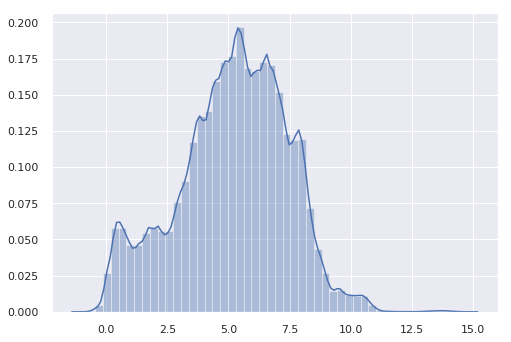

In [39]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


16

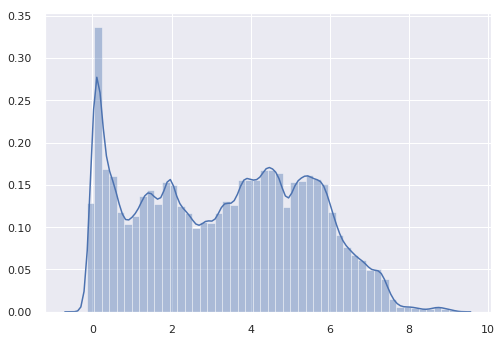

In [40]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

## Make submission file by 4 meter types

In [41]:
sample_submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [42]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [43]:
#sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')
sample_submission.head()

,row_id,meter_reading
0,0,96.739705
1,1,48.728141
2,2,4.909040
3,3,151.922766
4,4,741.228767
